# Pangea Bio Case Study

#### 1.1. Initialise R within python using rpy2

In [91]:
%load_ext rpy2.ipython
import rpy2.robjects as robjects

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


#### 1.2. Python EDA - Raw Data Import and #Spectra

In [92]:
# Import pyopenms and pandas
import pyopenms as oms
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the mzXML files
extract = oms.MSExperiment()
oms.MzXMLFile().load("sync/Data/extract.mzXML", extract)
blank = oms.MSExperiment()
oms.MzXMLFile().load("sync/Data/blank.mzXML", blank)

# Print the number of spectra in each file
print(f"Extract #Spectra = {extract.getNrSpectra()}")
print(f"Blank #Spectra = {blank.getNrSpectra()}")

# Check scan polarity
extract_acq_polarity = pd.Series([(spec.getInstrumentSettings().getPolarity()) for spec in extract])
print(f"Extract spectra polarity value counts:\n {extract_acq_polarity.value_counts()}\n")
blank_acq_polarity = pd.Series([(spec.getInstrumentSettings().getPolarity()) for spec in blank])
print(f"Blank spectra polarity value counts:\n {blank_acq_polarity.value_counts()}")

Extract #Spectra = 14163
Blank #Spectra = 14158
Extract spectra polarity value counts:
 1    14163
Name: count, dtype: int64

Blank spectra polarity value counts:
 1    14158
Name: count, dtype: int64


All spectra were acquired under +ve ionisation (with manual reference two the mzXML file).

#### 1.3. Python EDA - Total Ion Chromatograms

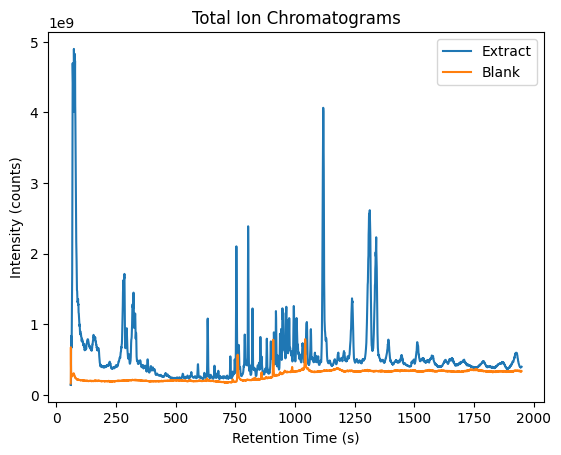

In [93]:
# Extract TIC data looping over spectra in MSExperiment()
RT_extract = []
I_extract = []
for spec in extract:
    if spec.getMSLevel() == 1:
        RT_extract.append(spec.getRT())
        I_extract.append(sum(spec.get_peaks()[1]))

# Blank TIC data looping over spectra in MSExperiment()
RT_blank = []
I_blank = []
for spec in blank:
    if spec.getMSLevel() == 1:
        RT_blank.append(spec.getRT())
        I_blank.append(sum(spec.get_peaks()[1]))

# Create a pandas DataFrame
TIC_df_extract = pd.DataFrame({'RT_extract': RT_extract, 'I_extract': I_extract})
TIC_df_blank = pd.DataFrame({'RT_blank': RT_blank, 'I_blank': I_blank})

# Plot the TIC data
sns.lineplot(x=RT_extract, y=I_extract, data=TIC_df_extract, label="Extract")
sns.lineplot(x=RT_blank, y=I_blank, data=TIC_df_blank, label="Blank")
plt.title("Total Ion Chromatograms")
plt.xlabel("Retention Time (s)")
plt.ylabel("Intensity (counts)")
plt.show()

#### 1.4. Python EDA - XIC 298.0967

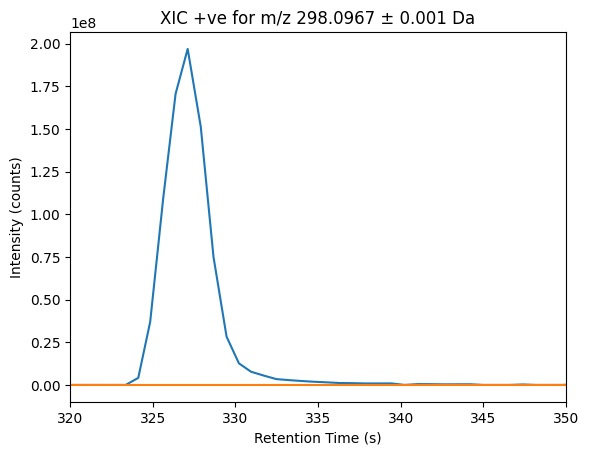

In [95]:
extract_ms1 = oms.MSExperiment()
for spec in extract.getSpectra():
    if spec.getMSLevel() == 1:
        extract_ms1.addSpectrum(spec)
        
blank_ms1 = oms.MSExperiment()
for spec in blank.getSpectra():
    if spec.getMSLevel() == 1:
        blank_ms1.addSpectrum(spec)

mz_value = 298.0967
mz_window = 0.001  # Total window size (± Da)

transition = oms.ReactionMonitoringTransition()
transition.setPrecursorMZ(mz_value)
transition.setProductMZ(mz_value)  # For MS1, precursor and product m/z are the same
transition.setLibraryIntensity(1.0)
transition.setNativeID(f"XIC {mz_value}@{mz_value} +ve")

targeted_exp = oms.TargetedExperiment()
targeted_exp.addTransition(transition)

extractor = oms.ChromatogramExtractor()
extract_298_0967 = oms.MSExperiment()
extractor.extractChromatograms(
    extract_ms1,  # Input experiment
    extract_298_0967,  # Output experiment to store chromatograms
    targeted_exp,  # Targeted experiment with transitions
    mz_window,  # Extraction window
    False,  # Use ppm (False means Da)
    oms.TransformationDescription(),  # No RT transformation
    -1,  # Extract over the full RT range
    "tophat"  # Extraction filter
)

extractor = oms.ChromatogramExtractor()
blank_298_0967 = oms.MSExperiment()
extractor.extractChromatograms(
    blank_ms1,  # Input experiment
    blank_298_0967,  # Output experiment to store chromatograms
    targeted_exp,  # Targeted experiment with transitions
    mz_window,  # Extraction window
    False,  # Use ppm (False means Da)
    oms.TransformationDescription(),  # No RT transformation
    -1,  # Extract over the full RT range
    "tophat"  # Extraction filter
)

extract_xic_298_0967 = extract_298_0967.getChromatogram(0)
extract_rt, extract_intensity = extract_xic_298_0967.get_peaks()
blank_xic_298_0967 = blank_298_0967.getChromatogram(0)
blank_rt, blank_intensity = blank_xic_298_0967.get_peaks()


sns.lineplot(x=extract_rt, y=extract_intensity)
sns.lineplot(x=blank_rt, y=blank_intensity)
plt.xlabel("Retention Time (s)")
plt.ylabel("Intensity (counts)")
plt.xlim(320, 350)
plt.title(f"XIC +ve for m/z {mz_value} ± {mz_window} Da")
plt.show()

